In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
myhost = os.uname()[1]
if myhost == 'macmazzitelli.lnf.infn.it':
    mybasepath = '/Users/mazzitel/Dropbox/GR2/soft/data/'
    posix=False
else:
    mybasepath = '/workarea/cloud-storage/mazzitel/'
    posix=True
print("Host:", myhost)
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '2':
    mybasepath = './'
    posix=False
    print('Running on CoLab')

Welcome to JupyROOT 6.22/06
Host: ec70b887765e
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f1b202b34a8>


In [2]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
    
def histGaus(var, bins, ax, color='b', xrange=False, alpha=1, label=''):
    from sklearn.metrics import r2_score
    from scipy.stats import chisquare
    import scipy.stats as stats
    if xrange:
        ax.hist(var, bins=bins, label=label, color=color, range=(xrange[0], xrange[1]), alpha=alpha)
        y, bins_edge = np.histogram(var, bins=bins, range=(xrange[0], xrange[1]))
    else:
        ax.hist(var, bins=bins, label=label, color=color)
        y, bins_edge = np.histogram(var, bins=bins)
    p0=[y.max(),bins_edge[y.argmax()], var.std()]
    x = np.linspace(bins_edge[0], bins_edge[-1], bins)
    popt, pcov = curve_fit(Gauss3, x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, Gauss3(x, *popt))
    x = np.linspace(bins_edge[0], bins_edge[-1], 100)
    sstat='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
    \nc = {4:.2f} +/- {5:.2f}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
    ax.plot(x,Gauss3(x, *popt), color+'--', label=sstat)
    return ax
def ExpG(x, p0, p1, a0, x0, s0): # power of ten
    import numpy as np
    return p0*np.exp(p1*x) + a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Exp(x, p0, p1): # power of ten
    import numpy as np
    return p0*np.exp(p1*x)

def G3(x, a0, x0, s0): # power of ten
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def myExpG(data,ax, xmin, xmax, bins, E0, E1, a0, x0, s0):
    y = data[(data > xmin) & (data < xmax)]
    binsf = int(bins*((xmax-xmin)/(y.max()-y.min())))
    x=np.linspace(xmin , xmax, binsf)
    yh, _ = np.histogram(y, bins=binsf, range=(xmin,xmax))
    popt, pcov = curve_fit(ExpG, x, yh, 
                            p0=(E0, E1, a0, x0, s0))    
    #print ("Params: ", popt) 
    perr = np.sqrt(np.diag(pcov))
    #print ("err: ", perr)
    # plt.title(r'E0*$e^{(E1*x)}$ + a0*$e^{-\frac{(x - x0)^2}{2*s0^2}}$', fontsize=30)
    ax.plot(x, ExpG(x, *popt), 'r--', linewidth=2,
    label='E0 = %.2e +/- %.2e\nE1 = %.2e +/- %.2e\na0 = %.2e +/- %.2e\nx0 = %.2e +/- %.2e\ns0 = %.2e +/- %.2e' % 
                          (popt[0], perr[0],  popt[1],perr[1],
                           popt[2],perr[2], popt[3], perr[3], popt[4], perr[4]))
    ax.plot(x, G3(x, popt[2], popt[3], popt[4]), 'b-', label='signal')
    ax.plot(x, Exp(x, popt[0], popt[1]), 'y-', label='background')
    return ax, popt




In [3]:
#
# carica i dati dal file
#

file_out=mybasepath+"out/dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz"
file_out=mybasepath+"out/dbscan_run4184_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4183.plk.gz"

df = pd.read_pickle(file_out, compression='gzip')

# range
# charge distribution
# charge asimettriy

df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.
df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

In [4]:
df

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,width,height,pearson,length,x0c,y0c
1,0.0,0.0,69.0,944.485,13.688188,1088.0,141.0,1089.0,155.0,18.135497,20.229902,0.060308,14.035669,1088.5,148.0
2,0.0,1.0,64.0,845.120,13.205000,1213.0,177.0,1220.0,190.0,16.564769,18.267846,0.064454,14.764823,1216.5,183.5
3,0.0,2.0,99.0,1278.670,12.915859,1106.0,183.0,1112.0,199.0,19.600141,24.030555,-0.081588,17.088007,1109.0,191.0
4,0.0,3.0,84.0,1149.545,13.685060,1391.0,186.0,1392.0,200.0,20.831414,21.759454,0.044315,14.035669,1391.5,193.0
5,0.0,4.0,73.0,935.875,12.820205,734.0,188.0,737.0,200.0,17.766833,21.395999,-0.161577,12.369317,735.5,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66991,199.0,306.0,122.0,1584.555,12.988156,1202.0,2090.0,1206.0,2109.0,18.833009,28.375392,-0.108505,19.416488,1204.0,2099.5
66992,199.0,307.0,64.0,865.115,13.517422,1668.0,2111.0,1664.0,2124.0,16.961357,19.135475,-0.145580,13.601471,1666.0,2117.5
66993,199.0,308.0,126.0,1581.645,12.552738,827.0,2148.0,835.0,2167.0,20.677750,27.577735,0.016015,20.615528,831.0,2157.5
66994,199.0,309.0,136.0,1876.615,13.798640,1183.0,2150.0,1185.0,2172.0,22.582100,27.264724,0.187476,22.090722,1184.0,2161.0


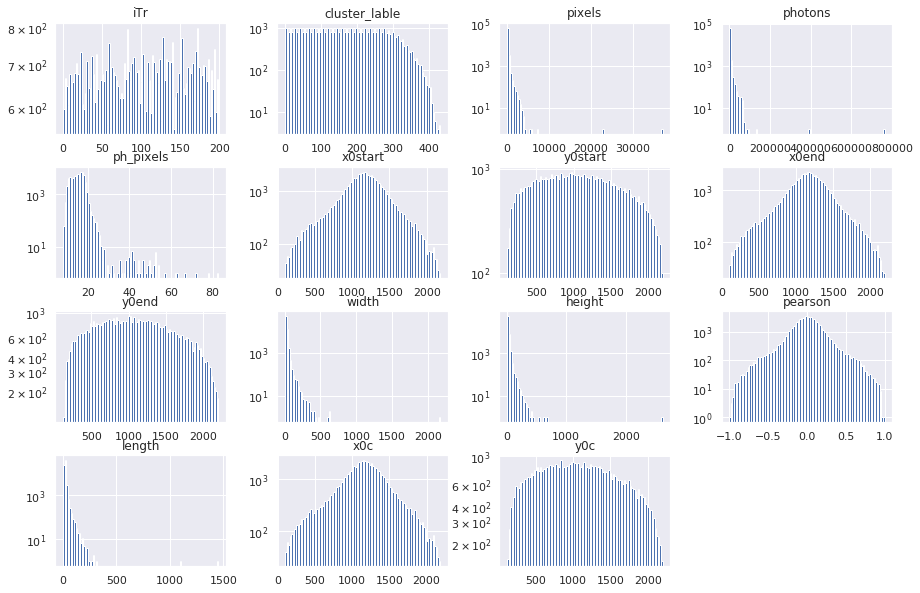

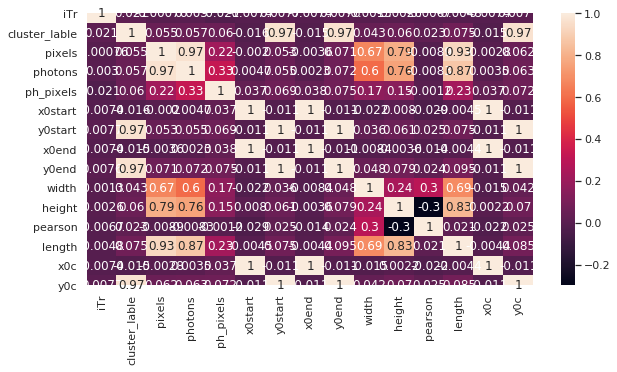

In [5]:
import seaborn as sns
sns.set()
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

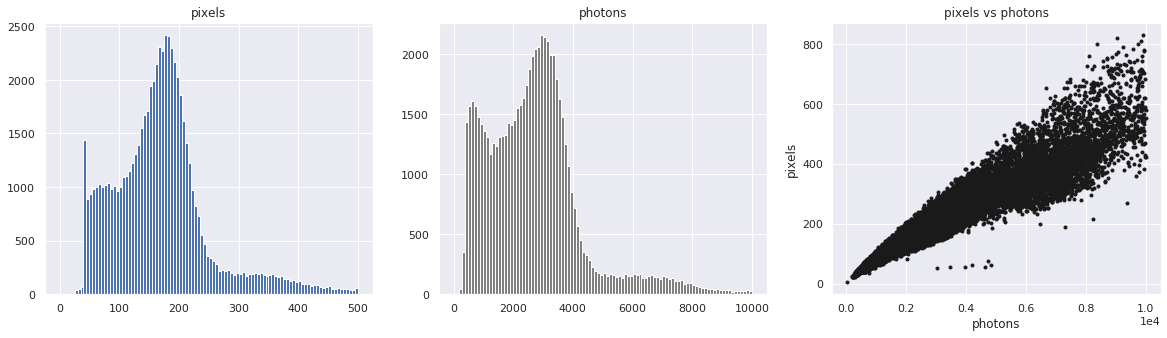

In [6]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
ax[0].set_title('pixels')
ax[0].hist(df.pixels, 100, range=(0,500))
ax[1].set_title('photons')
phmax=10000
ax[1].hist(df.photons, 100, range=(0,phmax), color="gray")
ax[1].hist(df.photons[df.pearson>0.8], 100, range=(0,phmax), color="green")
ax[2].set_title('pixels vs photons')
ax[2].plot(df.photons[df.photons<phmax].values, df.pixels[df.photons<phmax].values, 'k.')
ax[2].set_xlabel('photons')
ax[2].set_ylabel('pixels')
ax[2].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')
plt.show()

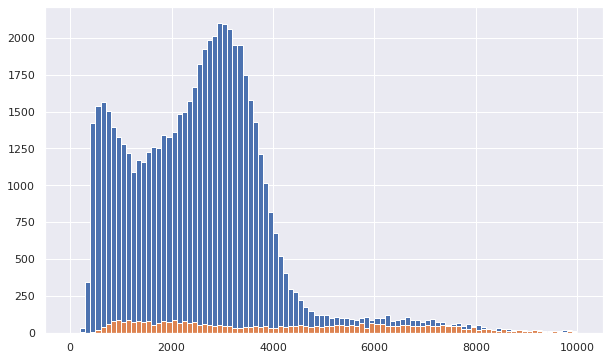

In [7]:
#
# Visualizziamo i fotoni
#
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.photons[abs(df.pearson)<0.4], 100, range=(0,10000))
ax.hist(df.photons[abs(df.pearson)>0.4], 100, range=(0,10000))
#ax.set_yscale('log')
plt.show()

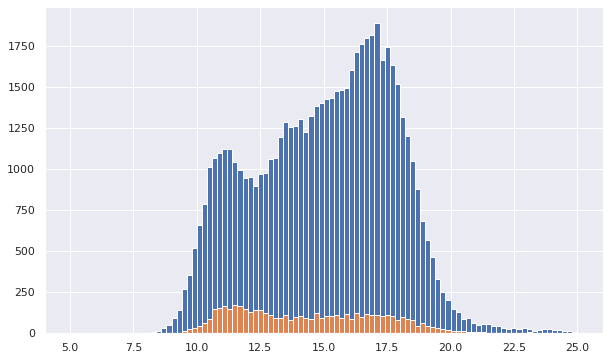

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.ph_pixels[abs(df.pearson)<0.4], 100, range=(5,25))
ax.hist(df.ph_pixels[abs(df.pearson)>0.4], 100, range=(5,25))
#ax.set_yscale('log')
plt.show()

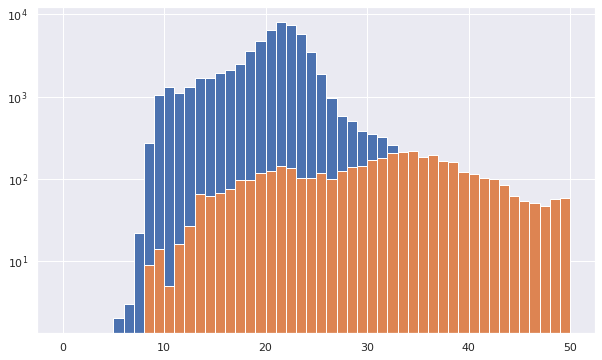

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.length[abs(df.pearson)<0.4], 50, range=(0,50))
ax.hist(df.length[abs(df.pearson)>0.4], 50, range=(0,50))
ax.set_yscale('log')
plt.show()

Fidical Circle: 75.00 [mm]


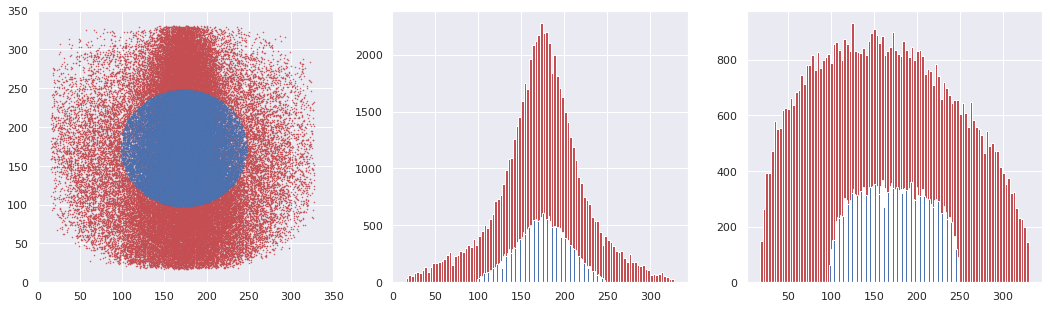

In [11]:
pd.set_option('mode.chained_assignment', None)

# Normalization

LEMON = False

if LEMON:
    # LEMON
    pixelscale  = 0.125 
    x_resolution = y_resolution = 2048
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale

    # fiducializzation

    DX = -15 
    DY = -20
    a = 100. # mm 
    b = 120. # mm

    a0 = a*0.5
    b0 = b*0.5
    #################################################


    print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(18, 5))

    y = df['y0c'].values
    x = df['x0c'].values
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
    ax[0].plot(x, y, 'r.', markersize=1)
    ax[0].plot(x1, y1, 'b.', markersize=1)
    ax[0].set_xlim(0,256)
    ax[0].set_ylim(0,256)
    ax[1].hist(x, color='r',bins=100)
    ax[1].hist(x1, color='b',bins=100)
    ax[2].hist(y, color='r',bins=100)
    ax[2].hist(y1, color='b',bins=100)
    plt.show()

    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/b0**2 )< 1]
else:
    
    # LIME
    DX = 0 
    DY = 0

    pixelscale  = 0.150 
    x_resolution = y_resolution = 2304


    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    
    a0 = 150*.5
    print ("Fidical Circle: %.2f [mm]" % (a0))
    d0 = x_resolution*pixelscale/2

    fig, ax = plt.subplots(1,3, figsize=(18, 5))

    y = df['y0c'].values
    x = df['x0c'].values
    x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/a0**2 )< 1]
    y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/a0**2 )< 1]
    ax[0].plot(x, y, 'r.', markersize=1)
    ax[0].plot(x1, y1, 'b.', markersize=1)
    ax[0].set_xlim(0,350)
    ax[0].set_ylim(0,350)
    ax[1].hist(x, color='r',bins=100)
    ax[1].hist(x1, color='b',bins=100)
    ax[2].hist(y, color='r',bins=100)
    ax[2].hist(y1, color='b',bins=100)
    plt.show()

    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]

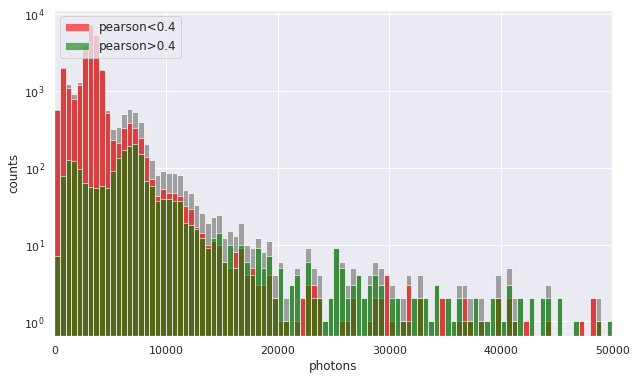

In [12]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
hmax = 50000.
#myExpG(dfc['photons'], ax, xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.001, a0=900., x0=3000., s0=300.)
ax.hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('photons')
ax.set_ylabel('counts')
ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

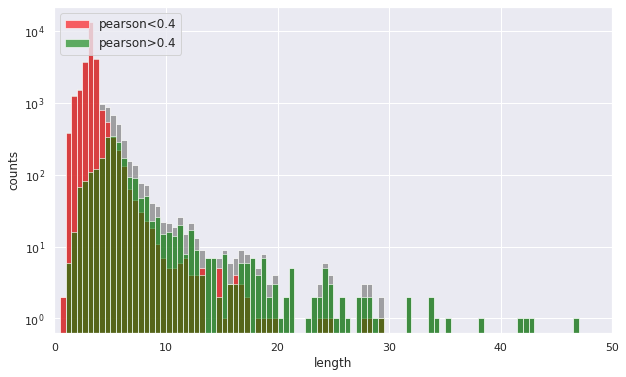

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
hmax=50
ax.hist(df.length, bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(df.length[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
ax.hist(df.length[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
ax.set_xlim(0,hmax)
ax.set_xlabel('length')
ax.set_ylabel('counts')
ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist2d(dfc.photons.values[(dfc.pixels<500)], 
           dfc.pixels.values[(dfc.pixels<500)], 
           bins=(20,20), cmap=plt.cm.jet)
ax[0].set_xlabel("photons")
ax[0].set_ylabel("pixels")
ax[1].hist2d(dfc.ph_pixels.values[(dfc.pixels<500)], 
           dfc.pixels.values[(dfc.pixels<500)], 
           bins=(20,20), cmap=plt.cm.jet)
ax[1].set_xlabel("photons/pixels")
plt.show()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib64/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.

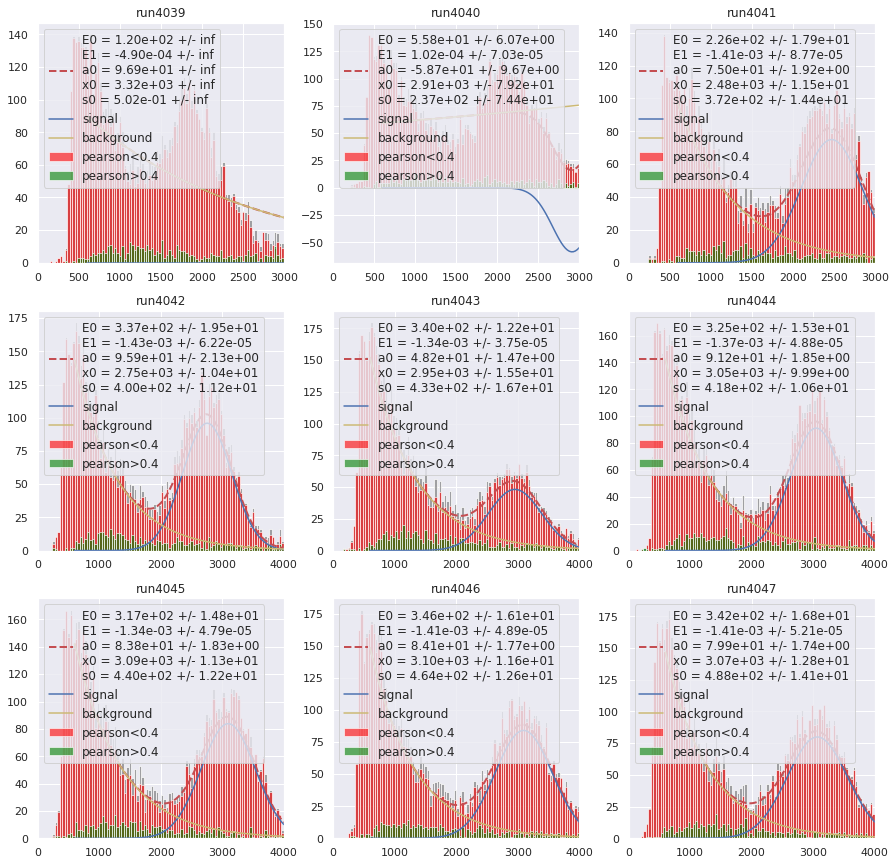

In [29]:
file_out=["dbscan_run4184_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4176_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4168_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4160_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4152_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4144_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4136_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_197_ped_4183.plk.gz",
         "dbscan_run4128_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz",
         "dbscan_run4120_cmin_0_cmax_500_rescale_576_nsigma_1.5_ev_200_ped_4183.plk.gz"]

d = {'run': [4184, 4176, 4160, 4168, 4152, 4144, 4136, 4128, 4120], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}

file_out=["dbscan_run4039_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4040_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4041_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4042_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4043_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4044_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4045_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4046_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz",
         "dbscan_run4047_cmin_0_cmax_500_rescale_2304_nsigma_1.5_ev_200_ped_4038.plk.gz"]
d = {'run': [4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047], 'd': [6.5, 11, 16, 21, 26, 31, 36, 41, 46]}

info = pd.DataFrame(data=d)

m = []
s = []
pixelscale  = 0.150 
x_resolution = y_resolution = 2304
d0 = x_resolution*pixelscale/2

# agistare il numero di file alla dimesione dei run analizzati
fig, ax = plt.subplots(3,3, figsize=(15,15))
xi = 0
yi = 0

for i, file in enumerate(file_out):
    df = pd.read_pickle(mybasepath+"out/"+file, compression='gzip')

    df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
    df['x0c'] = (df['x0end'] + df['x0start'])/2.
    df['y0c'] = (df['y0end'] + df['y0start'])/2.
    df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]
    df['length']   =df['length']*pixelscale
    df['x0c']      =df['x0c']*pixelscale
    df['y0c']      =df['y0c']*pixelscale
    # print ("Fidical Circle: %.2f, %.2f [mm]" % (a,b))
    a0 = 150*.5
    df = df[((df['x0c']-d0)**2/a0**2 + (df['y0c']-d0)**2/a0**2 )< 1]
    bins = 100

    #fig, ax = plt.subplots(figsize=(10,6))
    ax[xi,yi].set_title('run'+str(info.iloc[i,0]))
    if i < 3:
        hmax = 3000.
    else:
        hmax = 4000.
    _, popt= myExpG(df['photons'], ax[xi,yi], xmin=600., xmax=hmax, bins=100, E0=200., E1=-0.01, a0=900., x0=3000., s0=300.)
    m.append(popt[3])
    s.append(popt[4])
    ax[xi,yi].hist(df['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
    ax[xi,yi].hist(df.photons[(abs(df.pearson)<0.4)], 100, range=(0,hmax), color="red", alpha=0.6, label="pearson<0.4")
    ax[xi,yi].hist(df.photons[(abs(df.pearson)>0.4)], 100, range=(0,hmax), color="green", alpha=0.6, label="pearson>0.4")
    ax[xi,yi].set_xlim(0,hmax)
    #ax.set_yscale("log")
    ax[xi,yi].legend(loc=2, prop={'size':'medium'})
    #plt.minorticks_on()
    yi+=1
    if yi == 3:
        xi+=1
        yi = 0
plt.show()
info['m'] = m
info['s']= s

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(20,4))
ax[0].set_ylabel("photons")
ax[0].set_xlabel("ditance [cm]")
ax[0].plot(info.d.values, info.m.values)
ax[1].set_ylabel("sigma")
ax[1].set_xlabel("ditance [cm]")
ax[1].plot(info.d.values, info.s.values)
ax[2].set_ylabel("resolution")
ax[2].set_xlabel("ditance [cm]")
ax[0].set_ylim(2000,4000)
ax[1].set_ylim(300,700)
ax[2].plot(info.d.values, info.s.values/info.m.values)
#ax[0].set_ylim(2000,4000)
#ax[1].set_ylim(300,700)
plt.show()

In [ ]:
info.iloc[1,0]